In [1]:
import pandas as pd
import os
import ast
from collections import Counter
import seaborn as sns
import ast
import numpy as np
import matplotlib.pyplot as plt

### 1. Concat and remove duplicate labels in every boxes column

#### 1.1 Related functions for data preprocessing

In [6]:
# Define the file paths corresponding to each dynasty
dynasty_files = {
    "liaojin": [
        "output_liaojin.csv",
        "output_liaojin_museum.csv"
    ],
    "suitang": [
        "output_suitang.csv",
        "output_suitang_museum.csv"
    ],
    "song": [
        "book_song.csv",
        "museum_song1.csv"
    ],
    "ming": [
        "book_ming.csv",
        "museum_ming1.csv"
    ],
    "yuan": [
        "book_yuan.csv",
        "museum_yuan1.csv"
    ],
    "qing": [
        "book_qing.csv",
        "museum_qing1.csv"
    ]
}

# ========== core function ==========

def load_and_combine_files(dynasty_files):
    combined_dfs = []
    for dynasty, file_list in dynasty_files.items():
        for file_path in file_list:
            try:
                df = pd.read_csv(file_path)
                print(f"✅ Read success: {file_path}, rows: {len( df )}")
                if 'label' in df.columns and 'labels' not in df.columns:
                    df.rename(columns={'label': 'labels'}, inplace=True)
                elif 'labels' not in df.columns:
                    df['labels'] = None
                df['labels'] = df['labels'].astype(str)
                df['source_file'] = os.path.basename(file_path)
                df['dynasty'] = dynasty
                combined_dfs.append(df)
            except Exception as e:
                print(f"❌ Read failed: {file_path}, error: {e}")
    if not combined_dfs:
        raise ValueError("❗No files were loaded successfully, check the path and file contents!")
    return pd.concat(combined_dfs, ignore_index=True)

# Forced unification of boxes columns: all saved as strings, since the previous display detected 172 rows of boxes that were not strings
def ensure_boxes_str(value):
    if isinstance(value, str):
        return value
    elif isinstance(value, list):
        return str(value)
    else:
        return '[]'  # Empty or exceptions directly with an empty list

def extract_box_labels_unique(boxes_input):
    try:
        if isinstance(boxes_input, str):
            boxes_list = ast.literal_eval(boxes_input)
        elif isinstance(boxes_input, list):
            boxes_list = boxes_input
        else:
            return []
        unique_labels = list({box['label'] for box in boxes_list})
        return [{'label': label} for label in unique_labels]
    except Exception:
        return []

def extract_box_labels(boxes_input):
    try:
        if isinstance(boxes_input, str):
            boxes_list = ast.literal_eval(boxes_input)
        elif isinstance(boxes_input, list):
            boxes_list = boxes_input
        else:
            return []
        return [box['label'] for box in boxes_list]
    except Exception:
        return []

def extract_label_numbers(label_list):
    if isinstance(label_list, list):
        return label_list
    try:
        parsed = ast.literal_eval(label_list)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        return []
    return []

def count_boxes(df):
    all_labels = []
    for item in df['boxes']:
        all_labels.extend(extract_box_labels(item))
    return Counter(all_labels)

def count_labels(df):
    all_numbers = []
    for item in df['labels']:
        all_numbers.extend(extract_label_numbers(item))
    return Counter(all_numbers)
    

#### 1.2 Main process for getting our dataframe 

In [7]:
#Load data
all_combined = load_and_combine_files(dynasty_files)

all_combined['boxes'] = all_combined['boxes'].apply(ensure_boxes_str)

# Detect boxes column exception
invalid_boxes = all_combined[~all_combined['boxes'].apply(lambda x: isinstance(x, str))]
print(f"Detected {len( invalid_boxes )} row boxes non-string")

#Duplicate labels in boxes
all_combined['boxes'] = all_combined['boxes'].apply(extract_box_labels_unique)

all_combined.dtypes

✅ Read success: output_liaojin.csv, rows: 62
✅ Read success: output_liaojin_museum.csv, rows: 55
✅ Read success: output_suitang.csv, rows: 77
✅ Read success: output_suitang_museum.csv, rows: 90
✅ Read success: book_song.csv, rows: 84
✅ Read success: museum_song1.csv, rows: 47
✅ Read success: book_ming.csv, rows: 122
✅ Read success: museum_ming1.csv, rows: 75
✅ Read success: book_yuan.csv, rows: 87
✅ Read success: museum_yuan1.csv, rows: 58
✅ Read success: book_qing.csv, rows: 182
✅ Read success: museum_qing1.csv, rows: 314
Detected 0 row boxes non-string


ID             object
boxes          object
labels         object
source_file    object
dynasty        object
dtype: object

### 2. Statistical and data analysis and visualization
#### 2.1 Counting for boxes and labels

In [9]:
# Statistics by dynasty
boxes_stats = {}
labels_stats = {}

for dynasty, group_df in all_combined.groupby('dynasty'):
    boxes_stats[dynasty] = count_boxes(group_df)
    labels_stats[dynasty] = count_labels(group_df)

# Overall statistics
boxes_stats['all'] = count_boxes(all_combined)
labels_stats['all'] = count_labels(all_combined)

# Convert to DataFrame
boxes_df = pd.DataFrame(boxes_stats).fillna(0).astype(int)
labels_df = pd.DataFrame(labels_stats).fillna(0).astype(int)

# #Save statistics
# boxes_df.to_csv("boxes_label_frequency_by_dynasty.csv")
# labels_df.to_csv("labels_number_distribution_by_dynasty.csv")

In [10]:
boxes_df

,liaojin,ming,qing,song,suitang,yuan,all
figure,3,0,1,0,1,0,5
mountain tree,1,0,0,0,0,0,1
deer,15,0,1,1,3,1,21
翟鸟,2,0,0,0,0,1,3
plant,1,2,1,0,1,0,5
...,...,...,...,...,...,...,...
金乌鸟,0,0,0,0,0,1,1
Repeating Abstract Motifs,0,0,0,0,0,1,1
麒麟纹,0,0,0,0,0,1,1
方搭纹,0,0,0,0,0,1,1


In [11]:
labels_df 

,liaojin,ming,qing,song,suitang,yuan,all
5,19,39,240,20,39,27,384
0,201,165,1014,74,268,314,2036
1,199,639,2655,498,395,666,5052
3,58,117,343,13,172,149,852
2,63,504,1272,73,54,100,2066
4,2,51,151,43,79,18,344
None,0,30,0,0,0,58,88
0: 5,0,0,1,0,0,0,1
1: 5,0,0,1,0,0,0,1
2: 0,0,0,1,0,0,0,1


#### 2.2 Initial visualization to identify problems

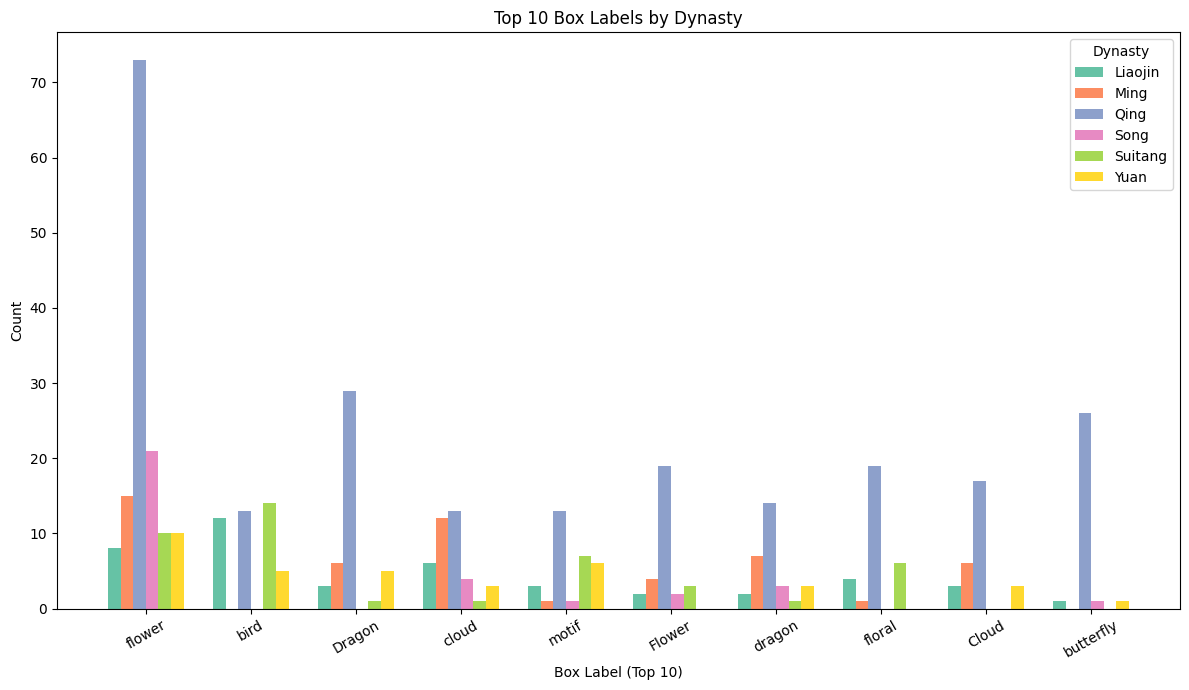

In [12]:
top_labels = boxes_df['all'].sort_values(ascending=False).head(10).index.tolist()
dynasties = [col for col in boxes_df.columns if col != 'all']
filtered_boxes_df = boxes_df.loc[top_labels, dynasties]

# Advanced colour matching with seaborn
colors = sns.color_palette("Set2", n_colors=len(dynasties))

# plot
x = np.arange(len(top_labels))
width = 0.12

plt.figure(figsize=(12, 7))
for i, dynasty in enumerate(dynasties):
    plt.bar(x + i * width, filtered_boxes_df[dynasty], width,
            label=dynasty.capitalize(), color=colors[i % len(colors)])

plt.xlabel('Box Label (Top 10)')
plt.ylabel('Count')
plt.title('Top 10 Box Labels by Dynasty')
plt.xticks(x + width * (len(dynasties) - 1) / 2, top_labels, rotation=30)
plt.legend(title='Dynasty')
plt.tight_layout()
plt.show()


Visualisation of boxes is now meaningless:
1. case is not standardised
2. There are many meaningless labels
3. Chinese labels are not translated

In [13]:
# Make sure the index is a string
labels_df.index = labels_df.index.astype(str)

# Defining replacement mappings
category_map = {
    '0': "animals",
    '1': "plants",
    '2': "inanimate objects",
    '3': "geometric patterns",
    '4': "textual motifs",
    '5': "human motifs",
    'None': "Uncategorized"
}

#Extracting the dynasties column
if 'all' in labels_df.columns:
    dynasties = [col for col in labels_df.columns if col != 'all']
else:
    dynasties = list(labels_df.columns)

# Filtering and renaming indexes
filtered_labels_df = labels_df.loc[labels_df.index.isin(category_map.keys())].copy()
filtered_labels_df = filtered_labels_df.rename(index=category_map)
percent_df = filtered_labels_df[dynasties].div(filtered_labels_df[dynasties].sum(axis=0), axis=1)

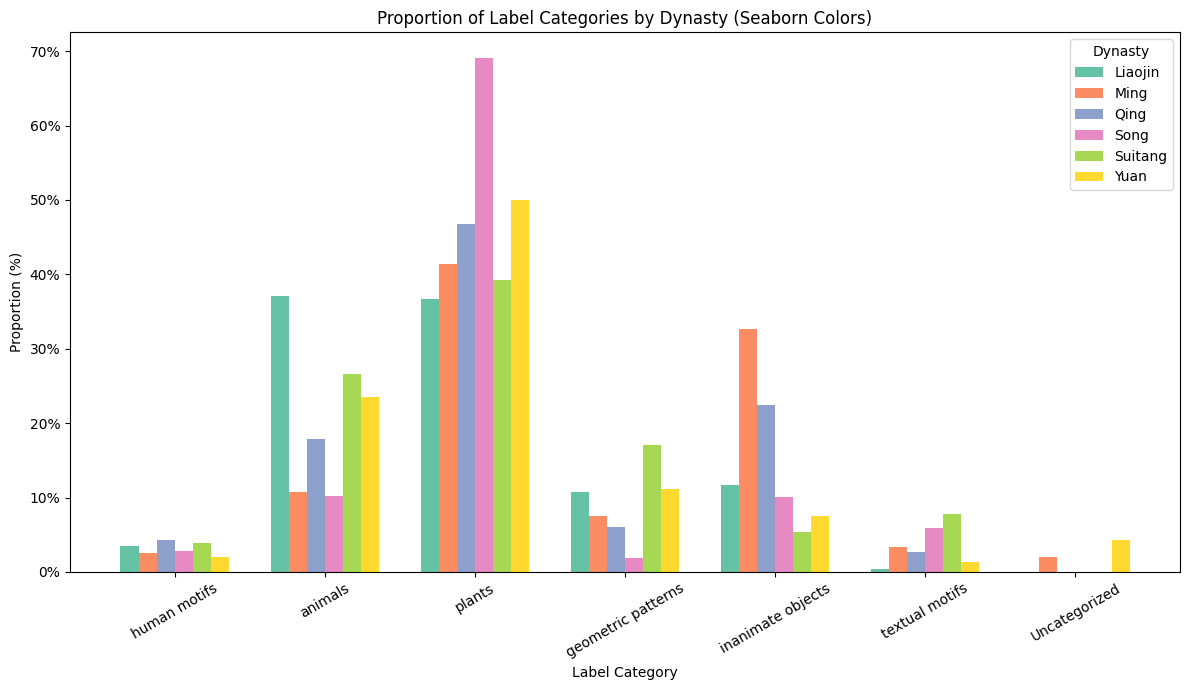

In [14]:
# seaborn 
colors = sns.color_palette("Set2", n_colors=len(dynasties))

categories = filtered_labels_df.index.tolist()
x = np.arange(len(categories))
width = 0.12

plt.figure(figsize=(12, 7))
for i, dynasty in enumerate(dynasties):
    plt.bar(x + i * width, percent_df[dynasty], width, label=dynasty.capitalize(), color=colors[i % len(colors)])

plt.xlabel('Label Category')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Label Categories by Dynasty (Seaborn Colors)')
plt.xticks(x + width * (len(dynasties) - 1) / 2, categories, rotation=30)
plt.legend(title='Dynasty')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.show()

### 3. Converting boxes' label names to English and Cleaning the content

#### 3.1 View the original unique boxes labels to locate the problem

In [15]:
all_box_labels = []

for b in all_combined['boxes']:
    try:
        # If it's a string, parse it into a list; if it's a list, parse it directly with the
        if isinstance(b, str):
            boxes_list = ast.literal_eval(b)
        elif isinstance(b, list):
            boxes_list = b
        else:
            continue
        
        # Extract label, convert to lowercase
        all_box_labels.extend([str(box['label']).lower() for box in boxes_list if 'label' in box])
    except Exception:
        continue

# Convert to DataFrame
box_labels_df = pd.DataFrame({'normalized_label': all_box_labels})

# Counting unique labels and frequency
unique_labels_df = box_labels_df['normalized_label'].value_counts().reset_index()
unique_labels_df.columns = ['box_label', 'count']

# Save to CSV
unique_labels_df.to_csv("unique_box_labels_lowercased.csv", index=False)
print("✅A unique_box_labels_lowercased.csv has been generated for checking all box labels.")

✅A unique_box_labels_lowercased.csv has been generated for checking all box labels.


#### 3.2 Define the conversion map

In [16]:
# Define translation mappings (extended version, including proprietary words such as flap areole)
translation_map = {
    '云': 'cloud',
    '花': 'flower',
    '牡丹': 'peony',
    '蝴蝶': 'butterfly',
    '鹤': 'crane',
    '凤凰': 'phoenix',
    '龙': 'dragon',
    '凤': 'phoenix',
    '山': 'mountain',
    '水波': 'wave',
    '人物': 'figure',
    '鸟': 'bird',
    '梅': 'plum blossom',
    '竹': 'bamboo',
    '鱼': 'fish',
    '鹿': 'beast',
    '虎': 'tiger',
    '狮': 'lion',
    '莲': 'lotus',
    '莲花': 'lotus',
    '菊花':'chrysanthemum',
    '瓣窠': 'petal cluster',
    '瓣窠纹': 'petal cluster',
    '瓣窠式': 'petal cluster',
    '芙蓉': 'hibiscus',
    '团纹': 'medallion',
    '博古': 'antiquities',
    # '博古纹': 'antiquities',
    '赤兔': 'red hare',
    '福': 'fu',
    '直线': 'straight line',
    '葡萄': 'grape',
    '锯齿球形': 'serrated sphere',
    '凤尾': 'phoenix tail',
    '蟠螭纹': 'coiled dragon',
    '方胜': 'square victory',
    '飞燕': 'flying swallow',
    '对马纹': 'paired horse',
    '仕女': 'court lady',
    '佛手': "Buddha's hand",
    '萱草纹': 'daylily',
    '童子骑羊': 'child riding goat',
    '锦鸡': 'golden pheasant',
    '金锭': 'gold ingot',
    '童子': 'child motif',
    '牛形动物纹样': 'ox-shaped animal',
    '夹缬': 'resist-dyed',
    '婴戏图': 'baby play scene',
    '如意吉祥纹': 'ruyi auspicious',
    '缠枝叶': 'intertwined branch and leaf',
    '斗牛纹': 'bullfighting',
    '柿蒂窠': 'persimmon calyx',
    '婴戏': 'baby play',
    '万字': 'swastika',
    '石榴': 'pomegranate',
    '对桃': 'paired peach',
    '奔兽': 'beast',
    '凤纹': 'phoenix',
    '海棠': 'begonia',
    '蝙蝠': 'bat',
    '琐纹': 'small linked',
    '盘长': 'endless knot',
    '盘凤': 'coiled phoenix',
    '海水纹样': 'sea wave',
    '球路流苏纹': 'ball-and-tassel',
    '翟纹': 'pheasant',
    '毬路': 'ball',
    '灵芝': 'lingzhi',
    '龟背纹': 'tortoise shell',
    '波斯文': 'Persian script',
    '缠枝': 'intertwined branches',
    '五湖四海纹': 'five lakes and four seas',
    '王': 'king symbol',
    '叶子': 'leaf',
    '菱格': 'rhombus',
    '葫芦': 'gourd',
    '蟒': 'python',
    '雁': 'wild goose',
    '龟甲纹': 'turtle shell',
    '卍': 'swastika',
    # '卍字': 'swastika',
    # '卍 字': 'swastika',
    # '卍字纹': 'swastika',
    '团窠': 'clustered medallion',
    '流水': 'flowing water',
    '灯笼': 'lantern',
    '杂宝': 'assorted treasures',
    '枝干': 'branches',
    # '寿字': 'longevity symbol',
    '寿': 'longevity symbol',
    '蝶': 'butterfly',
    '松枝': 'pine branch',
    '四合如意纹': 'four-in-one ruyi',
    # '力芬': 'lifen', 感觉是错误的可以delete
    '盘球纹': 'coiled ball',
    '联珠团窠': 'beaded clustered medallion',
    '柿蒂': 'persimmon calyx',
    '钱纹': 'coin',
    '八吉祥': 'eight auspicious symbols',
    '拱璧纹': 'arched jade disc',
    '卷草': 'scrolling grass',
    '卷草如意纹': 'scrolling grass',
    '梅竹纹样': 'plum and bamboo',
    '小窠宝花纹锦': 'small-cluster precious flower brocade',
    '宝花':'precious flower',
    '梅花': 'plum blossom',
    '盘长': 'endless knot',
    '折枝花卉纹样': 'broken branch floral',
    '赤兔纹': 'red hare',
    '对狮': 'paired lion',
    '灵芝云': 'lingzhi cloud',
    '喜相逢团纹': 'happy meeting medallion',
    '芙蓉花': 'hibiscus',
    '牡丹花': 'peony',
    '落花': 'falling flower',
    '宝相花': 'precious lotus',
    '圆芯朵梅纹': 'round-core plum blossom',
    '缠枝牡丹纹': 'intertwined peony',
    '串枝莲花纹': 'clustered lotus',
    '翟鸟': 'pheasant bird',
    '葫芦花': 'gourd flower',
    '团凤': 'paired phoenix',
    '波浪花纹': 'wave pattern',
    '波纹': 'wave pattern',
    '锁子纹': 'chain pattern',
    '兽': 'beast',

    '罐': 'pot',
    '鸂鶒': 'mandarin duck',
    '黑缎镶边': 'black satin edging',
    '土': 'earth / soil',
    '扇子': 'fan',
    '勾连纹': 'interlinked pattern',
    '盖': 'lid / cover',
    '阴阳叉': 'yin-yang fork',
    '日': 'sun',
    '胡旋舞人': 'Sogdian dancer',
    '江涯海水与桃树': 'seashore, water, and peach tree',
    '练雀': 'sparrow',
    '圆补': 'round patch',
    '‘富’‘贵’‘万岁’等文字纹样': 'character motifs',
    '飞鹰': 'flying eagle',
    '海水江崖': 'sea and cliff',
    '栏杆裙': 'railing-skirt',
    '宝瓶': 'precious vase',
    '圆盒': 'round box',
    '书籍': 'book / books',
    '如意': 'ruyi',
    '拱桥': 'arched bridge',
    '建筑': ' building',
    '波光粼粼的水面': 'shimmering water surface',
    '楼阁': 'pavilion',
    '撑船': 'boating',
    '孔雀': 'peacock',
    '孔 雀': 'peacock',
    '盆景': 'bonsai',
    '摆件': 'ornament',
    '谷穗': 'ear of grain',
    '水浪': 'water wave',
    '仙人': 'immortal / celestial being',
    # '道家帽子': 'Taoist hat',
    # '汉式长袍': 'Han-style robe', 同理，感觉也不是纹样
    '羽扇': 'feather fan',
    '拱 璧 纹': 'arched jade disc motif',
    '双矩': 'double square / double ruler',
    '鹭鸶': 'egret',
    '菱纹格': 'rhombus grid',
    '麒麟纹': 'qilin motif',
    '方搭纹': 'square lattice pattern',
    '月亮': 'moon',
    '日纹': 'sun',
    '桂树': 'cassia tree',
    '双胜纹': 'double-victory motif', # 不确定的翻译
    '窠形': 'cluster shape',
    '一年景': 'four seasons scene',
    '独 角 麒 麟': 'one-horned qilin',
    '海东青': 'gyrfalcon',
    '奔兔': 'running rabbit',
    '孔雀纹': 'peacock motif',
    # '纹': 'motif / pattern', # 无意义，可以删除
    '猪头': 'pig head',
    # '絹裤残片': 'silk trouser fragment', #不是纹样
    '珊瑚': 'coral',
    '书卷': 'book roll',
    '犀角': 'rhinoceros horn',
    '绿叶': 'green leaf',
    '海 螺': 'conch',
    '联珠纹': 'beaded motif',
    '回纹装饰': 'meander decoration',
    '叶': 'leaf',
    '联珠圈': 'beaded circle',
    '玉树': 'jade tree',
    # '圆领': 'round collar', 不是纹样
    '阿拉伯文': 'Arabic script',
    # '高筒绢袜': 'tall silk socks', 不是纹样
    # '罗鞋': 'silk shoes', # 不是纹样
    '秋': 'character motif',
    '岁': 'character motif',
    '千': 'character motif',
    '万': 'character motif',
    '球路': 'ball-shaped motif',
    '四 合 如 意 纹': 'four-in-one ruyi motif',
    '联珠': 'beaded motif',
    '异兽': 'exotic beast',
    '鹊': 'magpie',
    '带式联珠纹': 'belt-like beaded motif',
    '联珠纹样': 'beaded motif',
    '摩羯': 'makara (mythical creature)',
    '海水': 'sea wave',
    '玉兔': 'jade rabbit',

    '团花': 'clustered flower',
    '十字宾花': 'cross guest flower',
    '菱形方格纹': 'rhombus lattice pattern',
    '描金折枝花纹': 'gold-painted broken branch floral pattern',
    '蓮花': 'lotus',
    '桃形纹': 'peach-shaped pattern',
    '花蕾': 'flower bud',
    '海螺': 'conch',
    '金刚杵': 'vajra',
    '菱形': 'rhombus',
    '独角麒麟': 'one-horned qilin',
    '四季花': 'four seasons flowers',
    '小花纹': 'small flower pattern',
    '十字花纹': 'cross pattern',
    '拱璧纹': 'arched jade disc motif',
    '大洋花': 'ocean flower',
    '团荷花双喜字纹': 'clustered lotus with double happiness character pattern',
    '孔雀': 'peacock',
    '皮球花': 'ball flower',
    '花蓝': 'flower basket',
    '花草': 'flowers and grasses',
    'floral pattern':'floral',
    'floral motif':'floral',
    'clouds':'cloud'
    
}

# Commenting out this section outputs the original label display of unmatched boxes.
def translate_label(label):
    label_str = str(label).strip()
    
    #  perfect match first
    if label_str in translation_map:
        return translation_map[label_str]
    
    # preference partial match for long words
    for cn, en in sorted(translation_map.items(), key=lambda x: len(x[0]), reverse=True):
        if cn in label_str:
            return en
    
    # No match, retain original value or assign underwriting
    return label_str  # 或 return 'unknown'


In [17]:
# main_keywords = ['flower', 'blossom', 'bird', 'phoenix', 'dragon', 'figure', 'child', 'animal',
#                  'butterfly', 'fish', 'deer', 'beast', 'cloud', 'mountain', 'tortoise', 'ox',
#                  'hare', 'horse', 'pheasant']

# framework_keywords = ['pattern', 'knot', 'medallion', 'cluster', 'brocade', 'disc', 'frame',
#                       'scroll', 'lattice', 'grid', 'ruyi', 'chain', 'endless', 'coiled', 'beaded',
#                       'diamond', 'rhombus', 'cross', 'circular', 'wave', 'tassel', 'resist-dyed']

# def classify_motif(english_label):
#     lower_label = english_label.lower()
#     for kw in main_keywords:
#         if kw in lower_label:
#             return 'Main Part'
#     for kw in framework_keywords:
#         if kw in lower_label:
#             return 'Frame'
#     return 'unclassified'

In [18]:
box_labels_df_translated_label = box_labels_df.copy()
box_labels_df_translated_label['translated_label'] = box_labels_df_translated_label['normalized_label'].apply(translate_label)

# Unique items and frequency of statistics
unique_labels = box_labels_df_translated_label['translated_label'].value_counts().reset_index()
# unique_labels = box_labels_df['normalized_label'].value_counts().reset_index()

unique_labels.columns = ['label', 'count']

# Save as unique_box_labels.csv
unique_labels.to_csv("unique_box_labels.csv", index=False)

print("✅ Completed case harmonisation, translation and saving unique_box_labels.csv")


✅ Completed case harmonisation, translation and saving unique_box_labels.csv


#### 3.3 After manual cleaning on the map base, read the final csv and clean boxes_df

In [19]:
# Reload the manually modified CSV
filtered_csv = pd.read_csv("unique_box_labels_cleaned.csv")
valid_labels = set(filtered_csv['label'])

# Filter in box_labels_df_translated_label to keep only those labels that exist in the CSV
filtered_box_labels_df = box_labels_df_translated_label[
    box_labels_df_translated_label['translated_label'].isin(valid_labels)
].copy()

print(f"✅ Filtered with {len( filtered_box_labels_df )} rowsremaining")

✅ Filtered with 2169 rowsremaining


In [20]:
filtered_box_labels_df.to_csv("unique_box_labels_final.csv", index=False)

#### 3.4 Final visualization and analysis

1. World cloud for all and each dynasty

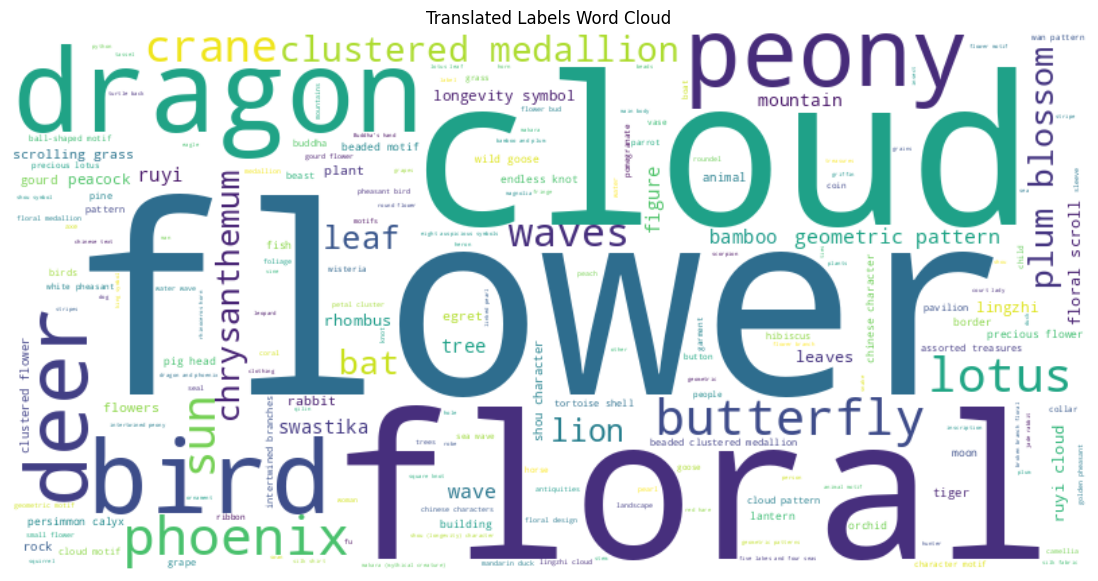

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare a word frequency dictionary
word_freq = filtered_box_labels_df['translated_label'].value_counts().to_dict()

# generated word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Show word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Translated Labels Word Cloud')
plt.show()


In [22]:
print("Available columns.", boxes_df.columns)
filtered_box_labels_df

Available columns. Index(['liaojin', 'ming', 'qing', 'song', 'suitang', 'yuan', 'all'], dtype='object')


,normalized_label,translated_label
0,figure,figure
1,mountain tree,mountain tree
2,deer,deer
3,翟鸟,pheasant bird
4,plant,plant
...,...,...
2241,海水纹样,sea wave
2242,flower tree,flower tree
2243,butterfly,butterfly
2244,swastika,swastika


In [23]:
def translate_label(label):
    label_str = str(label).strip()
    if label_str in translation_map:
        return translation_map[label_str]
    for cn, en in sorted(translation_map.items(), key=lambda x: len(x[0]), reverse=True):
        if cn in label_str:
            return en
    return label_str

translated_boxes_df = boxes_df.copy()
translated_boxes_df.index = translated_boxes_df.index.map(translate_label)

# Load manually cleaned CSV as a filter
filtered_csv = pd.read_csv("unique_box_labels_cleaned.csv")
valid_labels = set(filtered_csv['label'])


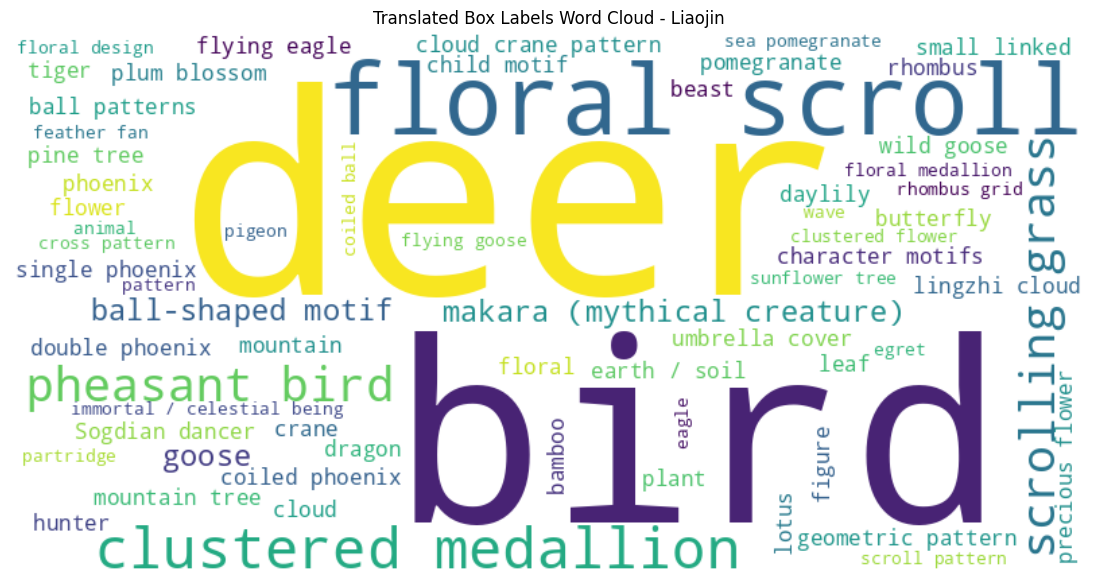

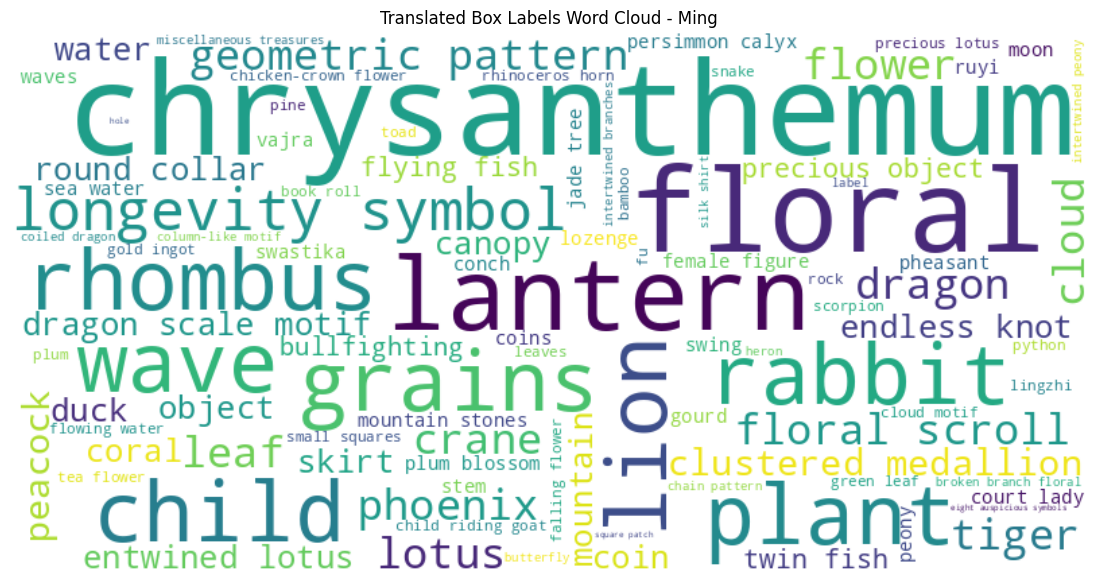

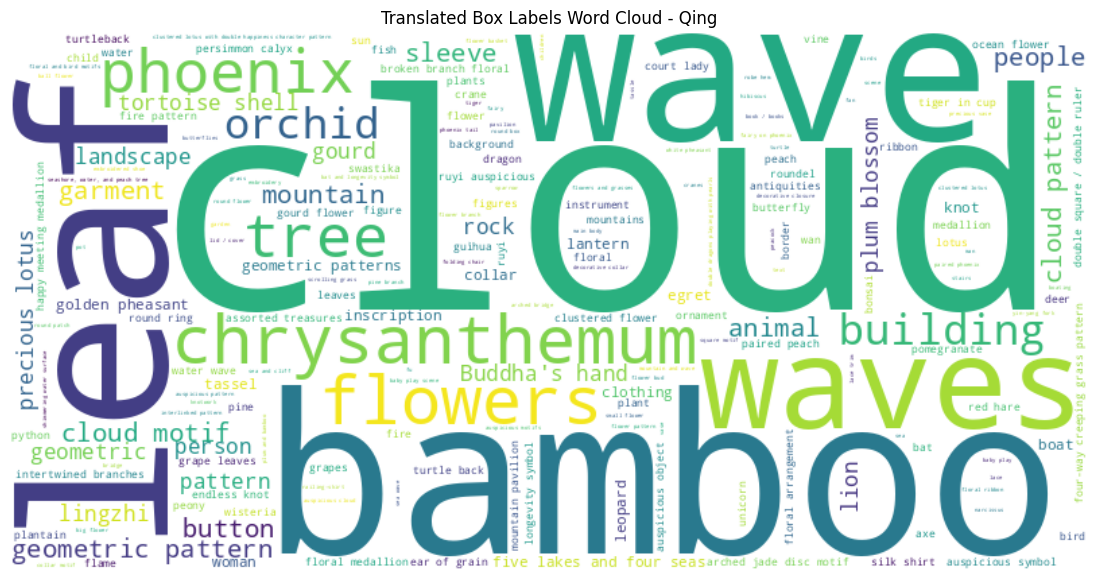

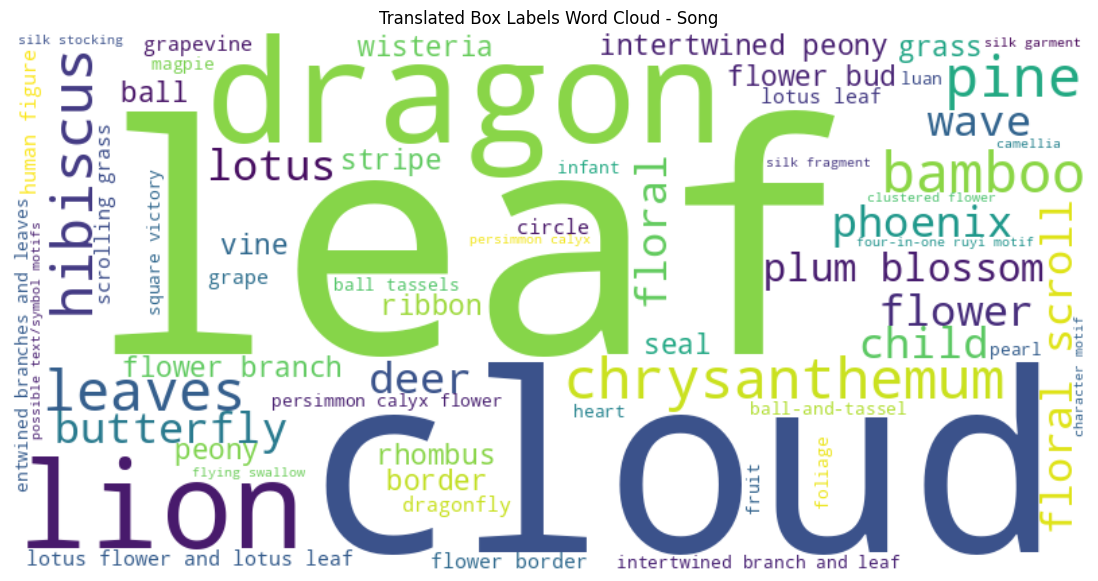

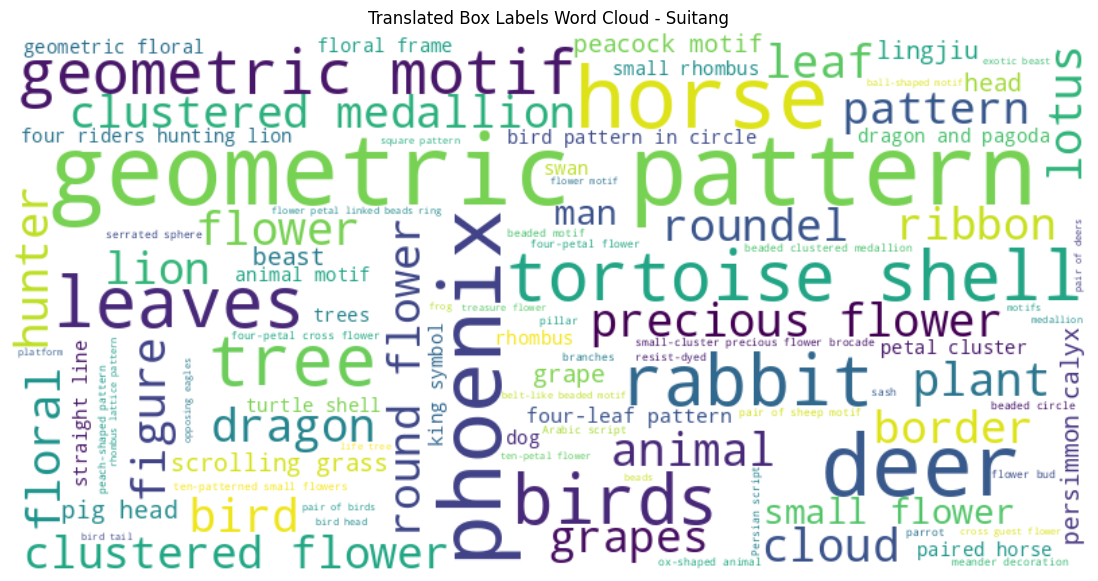

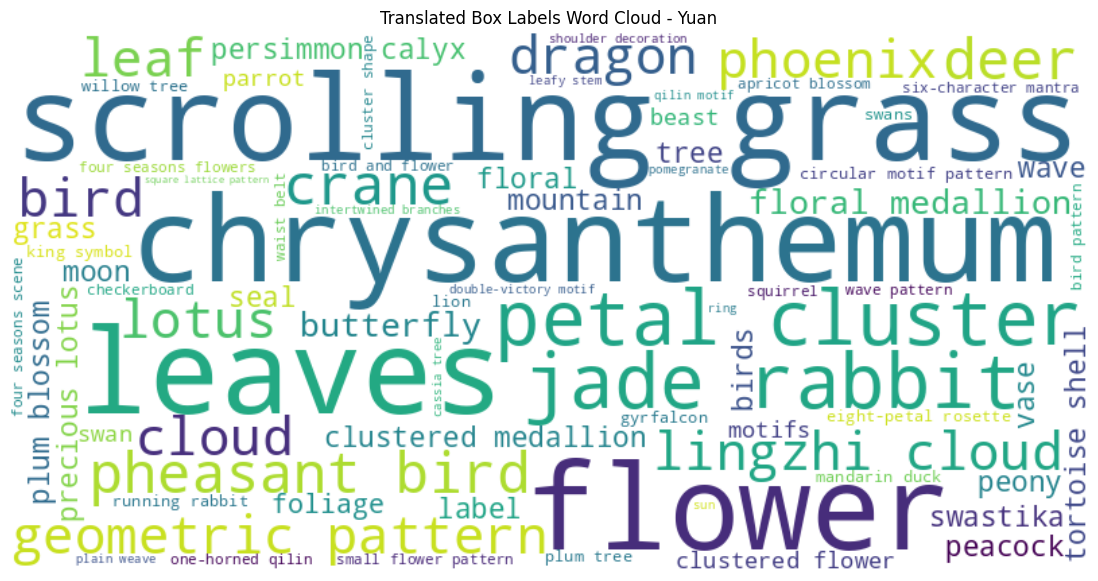

In [24]:
# Preserve labels present in CSV
translated_boxes_df = translated_boxes_df.loc[translated_boxes_df.index.isin(valid_labels)].copy()

# Remove the 'all' column and use only specific dynasties
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

#Generate word clouds by each dynasty
for dynasty in dynasties:
    word_freq = translated_boxes_df[dynasty][translated_boxes_df[dynasty] > 0].to_dict()

    if word_freq:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Translated Box Labels Word Cloud - {dynasty.capitalize()}')
        plt.show()

# for dynasty in dynasties:
#     dynasty_labels = boxes_df[dynasty][boxes_df[dynasty] > 0].index.unique()
#     word_freq = {label: 1 for label in dynasty_labels}  

#     if word_freq:
#         wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#         plt.figure(figsize=(15, 7))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')
#         plt.title(f'Translated Box Labels Word Cloud - {dynasty.capitalize()}')
#         plt.show()

In [25]:
results = []

for dynasty in dynasties:
    word_freq = translated_boxes_df[dynasty][translated_boxes_df[dynasty] > 0].to_dict()

    if word_freq:
        # counts 和 total
        counts = np.array(list(word_freq.values()))
        total = counts.sum()
        p = counts / total # Conversion ratio

        #Richness: number of non-zero categories
        richness = len(counts)

        # Entropy: -Σ pᵢ log(pᵢ)
        entropy = -np.sum(p * np.log(p + 1e-12))  # 防止 log(0)

        # Max entropy: log(richness)
        max_entropy = np.log(richness) if richness > 0 else 0

        #Evenness: actual entropy / maximum entropy
        evenness = entropy / max_entropy if max_entropy > 0 else 0

        results.append({
            'dynasty': dynasty,
            # 'richness': richness,
            'entropy': entropy,
            'evenness': evenness
        })


df_results = pd.DataFrame(results)
print(df_results)

   dynasty   entropy  evenness
0  liaojin  3.765542  0.898772
1     ming  4.479790  0.981474
2     qing  5.258190  0.964622
3     song  4.014447  0.965271
4  suitang  4.527861  0.985363
5     yuan  4.318627  0.994204


In [26]:
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

for dynasty in dynasties:
    top20 = translated_boxes_df[dynasty].sort_values(ascending=False).head(20)
    labels = top20.index.tolist()
    print(f"\n🔹 {dynasty.capitalize()} Dynasty Top 20 Labels:")
    print(', '.join(labels))


🔹 Liaojin Dynasty Top 20 Labels:
deer, bird, flower, cloud, phoenix, wild goose, floral, clustered medallion, floral scroll, figure, crane, cloud, makara (mythical creature), scrolling grass, goose, pheasant bird, cloud, ball-shaped motif, precious flower, dragon

🔹 Ming Dynasty Top 20 Labels:
flower, cloud, lotus, dragon, chrysanthemum, peony, floral, crane, gourd, lantern, flower, cloud, child, cloud, swastika, rabbit, lion, grains, rhombus, longevity symbol

🔹 Qing Dynasty Top 20 Labels:
flower, butterfly, floral, dragon, bird, cloud, floral, sun, peony, cloud, bamboo, floral, bat, plum blossom, wave, leaf, waves, lotus, chrysanthemum, peony

🔹 Song Dynasty Top 20 Labels:
flower, leaf, cloud, dragon, lion, chrysanthemum, plum blossom, leaves, bamboo, pine, floral, peony, hibiscus, flower, character motif, possible text/symbol motifs, four-in-one ruyi motif, square victory, heart, ball tassels

🔹 Suitang Dynasty Top 20 Labels:
bird, flower, floral, lion, floral, clustered medallion,

In [39]:
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

for dynasty in dynasties:
    top20 = translated_boxes_df[dynasty].sort_values(ascending=False).head(20)
    labels = top20.index.tolist()
    print(f"\n🔹 {dynasty.capitalize()} Dynasty Top 20 Labels:")
    print(', '.join(labels))


🔹 Liaojin Dynasty Top 20 Labels with Counts:
deer: 15
bird: 12
flower: 8
cloud: 6
phoenix: 6
wild goose: 4
floral: 4
clustered medallion: 3
floral scroll: 3
figure: 3
crane: 2
makara (mythical creature): 2
cloud: 2
goose: 2
pheasant bird: 2
ball-shaped motif: 2
cloud: 2
precious flower: 2
dragon: 2
scrolling grass: 2

🔹 Ming Dynasty Top 20 Labels with Counts:
flower: 15
cloud: 12
lotus: 7
dragon: 7
chrysanthemum: 5
peony: 5
floral: 4
crane: 3
gourd: 3
lantern: 3
flower: 3
cloud: 2
child: 2
cloud: 2
rabbit: 2
swastika: 2
lion: 2
grains: 2
rhombus: 2
longevity symbol: 2

🔹 Qing Dynasty Top 20 Labels with Counts:
flower: 73
butterfly: 26
floral: 19
dragon: 14
bird: 13
cloud: 13
floral: 11
sun: 8
peony: 7
plum blossom: 6
bamboo: 6
cloud: 6
bat: 6
floral: 6
peony: 5
chrysanthemum: 5
waves: 5
flowers: 5
lotus: 5
leaf: 5

🔹 Song Dynasty Top 20 Labels with Counts:
flower: 21
leaf: 7
cloud: 4
dragon: 3
lion: 2
chrysanthemum: 2
plum blossom: 2
leaves: 2
pine: 2
bamboo: 2
floral: 2
peony: 2
hibi

2. Similarity heat map

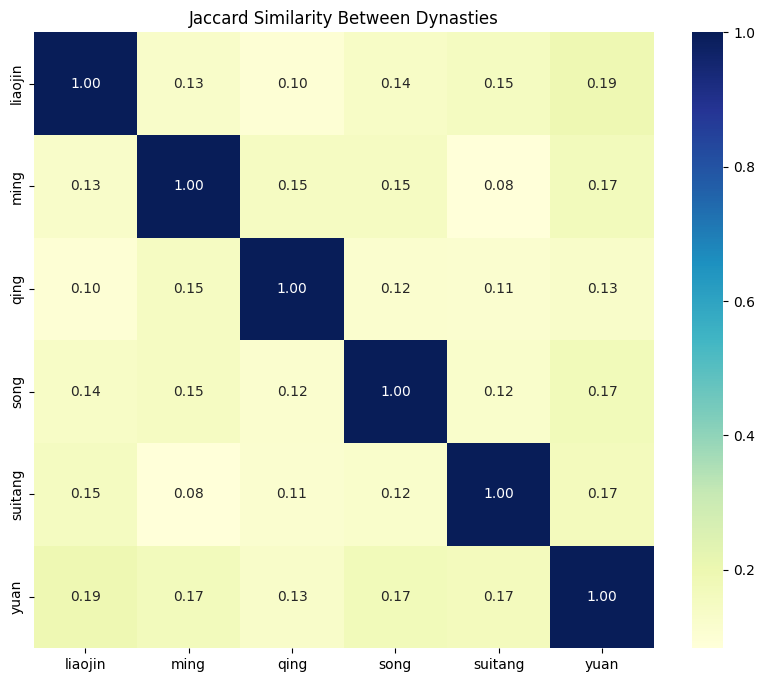

In [34]:
from itertools import combinations
from upsetplot import UpSet, from_memberships

dynasty_label_sets = {
    dynasty: set(translated_boxes_df.index[translated_boxes_df[dynasty] > 0])
    for dynasty in translated_boxes_df.columns if dynasty != 'all'
}

# Calculate the Jaccard similarity matrix
dynasties = list(dynasty_label_sets.keys())
jaccard_matrix = pd.DataFrame(0.0, index=dynasties, columns=dynasties)

for d1, d2 in combinations(dynasties, 2):
    set1, set2 = dynasty_label_sets[d1], dynasty_label_sets[d2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union != 0 else 0
    jaccard_matrix.loc[d1, d2] = jaccard
    jaccard_matrix.loc[d2, d1] = jaccard
np.fill_diagonal(jaccard_matrix.values, 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Jaccard Similarity Between Dynasties')
plt.show()


3. Top-N HF labelling UpSet plot code

/opt/anaconda3/envs/silk_env/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/opt/anaconda3/envs/silk_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fil


✅ 具体标签标注:
组合 liaojin+ming+qing+song+suitang+yuan: flower, dragon, leaf, lotus
组合 liaojin+qing+suitang+yuan: bird
组合 liaojin+ming+qing: cloud, cloud
组合 liaojin+ming+qing+suitang: floral, floral, floral
组合 liaojin: butterfly, phoenix, plum blossom
组合 liaojin+qing+song+suitang+yuan: deer
组合 ming+qing: chrysanthemum, peony
组合 ming+qing+song+suitang: lion
组合 liaojin+ming+qing+yuan: crane
组合 liaojin+ming+qing+suitang+yuan: geometric pattern
组合 liaojin+ming+qing+song+yuan: wave


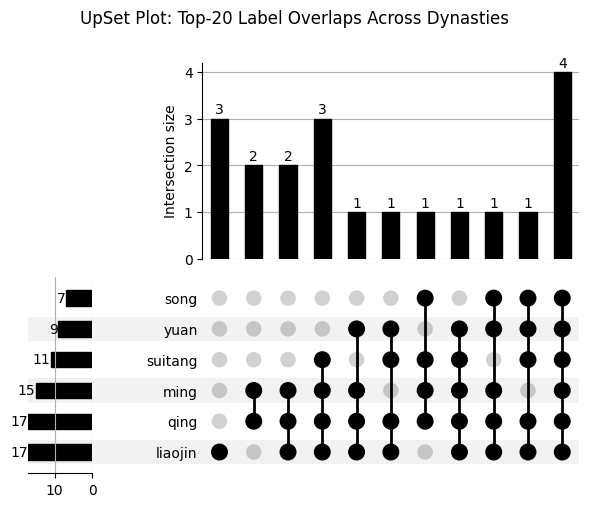

In [35]:
# Prepare Top-N labels
dynasties = [col for col in translated_boxes_df.columns if col != 'all']
N = 20
top_labels_series = translated_boxes_df[dynasties].sum(axis=1)
top_labels = top_labels_series.sort_values(ascending=False).head(N).index.tolist()

#Building membership lists and tag correspondences
memberships = []
label_map = {}
for label in top_labels:
    present_in = []
    for dyn in dynasties:
        try:
            value = translated_boxes_df.loc[label, dyn]
            if isinstance(value, pd.Series):
                value = value.iloc[0]
            if pd.notna(value) and np.isscalar(value) and float(value) > 0:
                present_in.append(dyn)
        except (KeyError, IndexError):
            continue
    if present_in:
        memberships.append(present_in)
        key = tuple(sorted(present_in))
        label_map.setdefault(key, []).append(label)

# Build upset data
if memberships:
    upset_data = from_memberships(memberships, data=[1] * len(memberships))

    fig = plt.figure(figsize=(12, 8))
    UpSet(upset_data, subset_size='count', show_counts=True).plot(fig=fig)
    plt.suptitle(f'UpSet Plot: Top-{N} Label Overlaps Across Dynasties')

    # Printed and labelled with specific labels
    print("\n✅Specific labelling.")
    for key, labels in label_map.items():
        combo = '+'.join(key)
        label_list = ', '.join(labels)
        print(f"组合 {combo}: {label_list}")

    plt.show()
else:
    print("There is no label intersection data available for UpSet analysis.Please check top_labels and the frequency matrix。")


The meaning of `top20` here is:


From `translated_boxes_df`, the sum across dynasties is calculated for each tag.
Then the top 20 most frequent tags are selected in descending order of their total frequency of occurrence.


In other words, the Top-20 tags ≈ the 20 most frequent and important motifs on a global (cross-dynasty) scale.


These tags are then used to analyse their distribution and intersection across dynasties, the
Namely:
- Which labels are found in more than one dynasty?
- Which labels appear only in individual dynasties?

But since the number varies from dynasty to dynasty, it's worth discussing whether this is informative or not

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


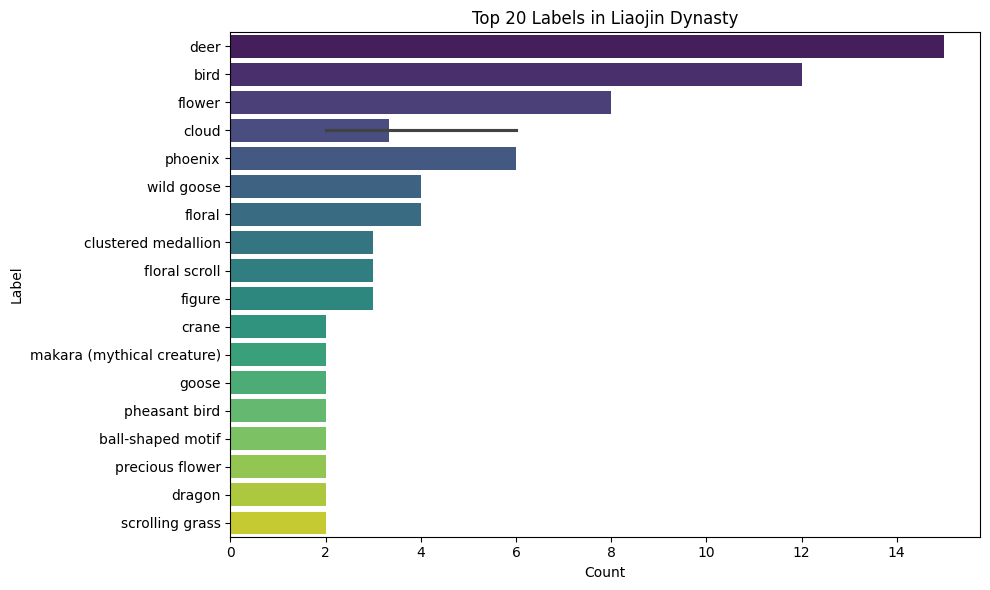

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


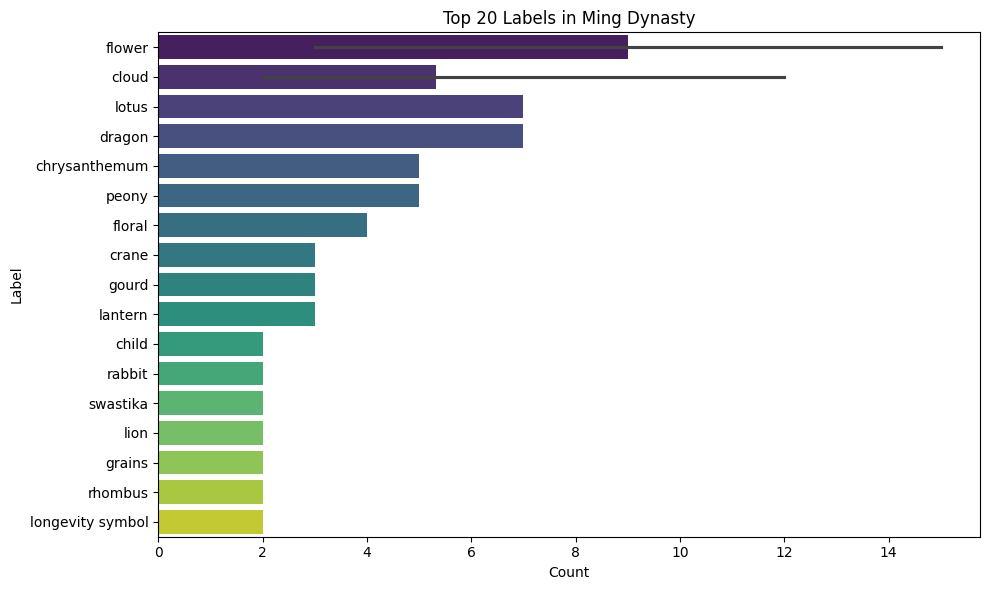

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


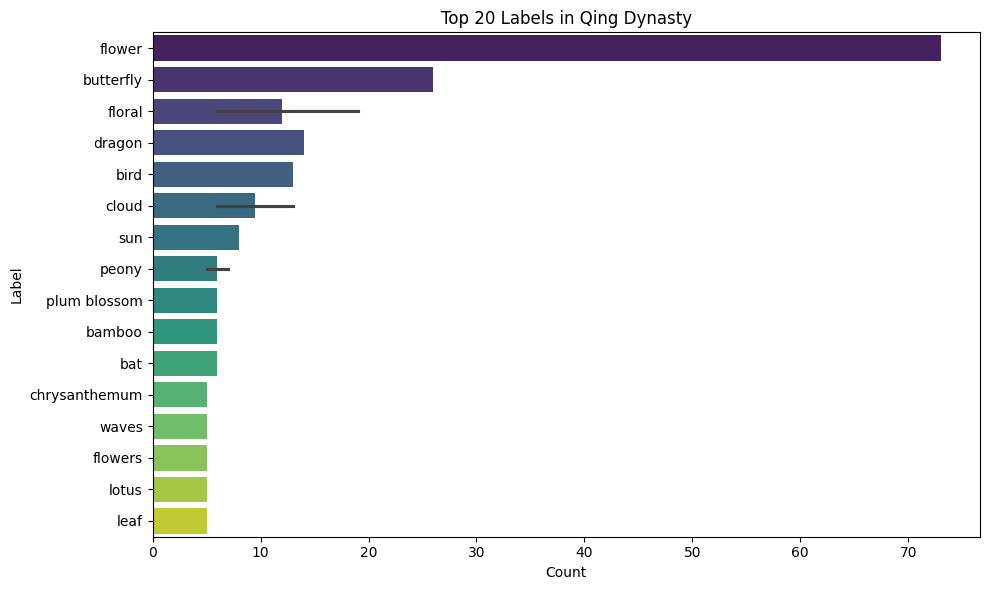

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


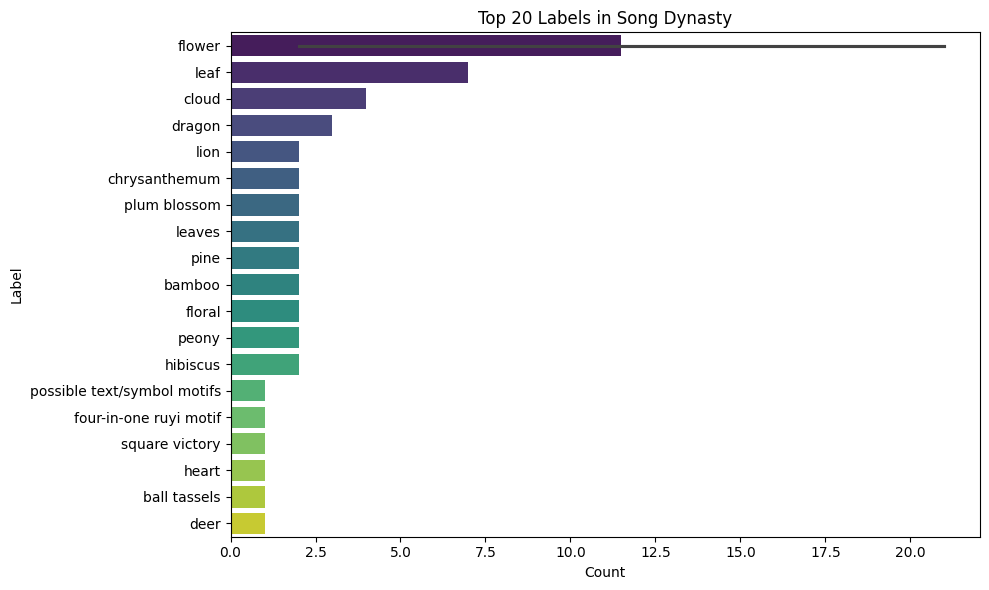

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


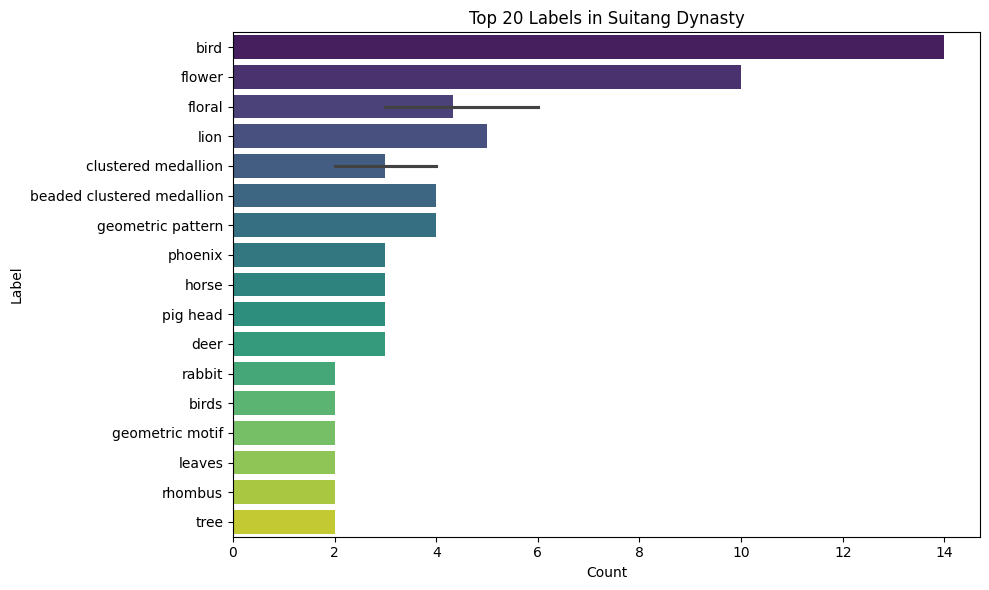

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_6245/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


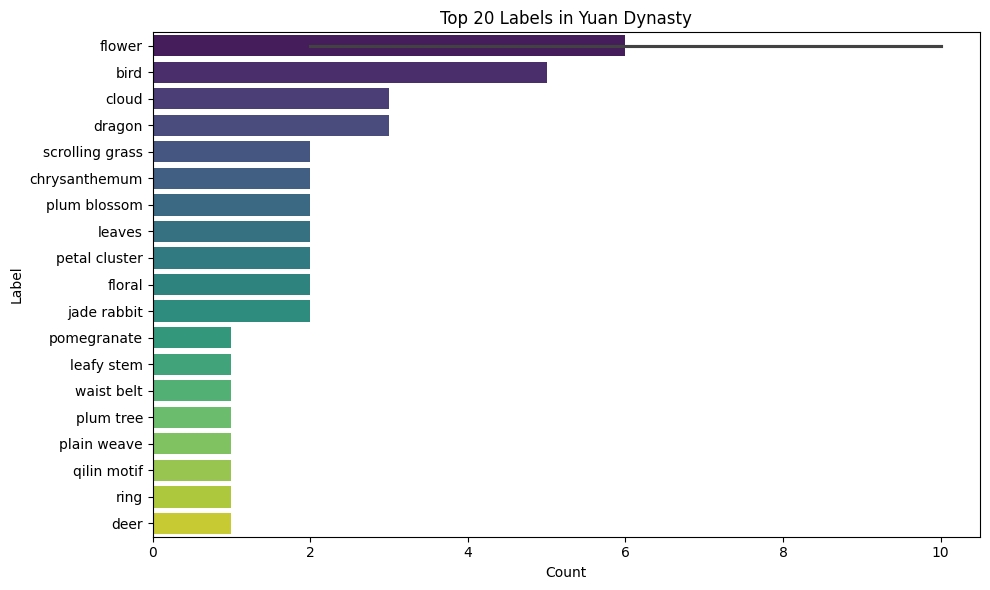

In [36]:
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

for dynasty in dynasties:
    top20 = translated_boxes_df[dynasty].sort_values(ascending=False).head(20)
    df_plot = pd.DataFrame({'label': top20.index, 'count': top20.values})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='count', y='label', palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.title(f'Top 20 Labels in {dynasty.capitalize()} Dynasty')
    plt.tight_layout()
    plt.show()